In [121]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn as sk
assert sk.__version__ >= "0.20"

# XGBoost Import
import xgboost as xgb
xgb.set_config(verbosity = 2)
# assert xgb.get_config["verbosity"] == 0

# Common imports
import numpy as np
import os
import pandas as pd
import seaborn as sns

# to make this notebook's output stable across runs
np.random.seed(0)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from IPython.display import display, HTML

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [122]:
# Get current directory of file (so filesystem should work regardless of user machine)
%cd ./syracuseBasketballCompetition
cwd = os.getcwd()
print(cwd)

# Read in data from sources
play_by_play_path = os.path.join(cwd, 'Data')
play_by_play_path = os.path.join(play_by_play_path, 'syracuse_gsw_basic_pbp.csv')
play_by_play_df = pd.read_csv(play_by_play_path)

results_path = os.path.join(cwd, 'Data')
results_path = os.path.join(results_path, "syracuse_gsw_basic_results.csv")
game_results_df = pd.read_csv(results_path)

game_data_master_path = os.path.join(cwd, 'Data')
game_data_master_path = os.path.join(game_data_master_path, 'game_data_master.csv')
game_data_master = pd.read_csv(game_data_master_path)


# Reset indices
play_by_play_df.set_index('id', inplace= True)
game_results_df.set_index('id', inplace= True)


[Errno 2] No such file or directory: './syracuseBasketballCompetition'
/Users/haydenoutlaw/Documents/Projects/syracuseBasketballCompetition
/Users/haydenoutlaw/Documents/Projects/syracuseBasketballCompetition


In [123]:
# What does the data look like?
play_by_play_df.head()

,season,season_type,nba_game_id,home,away,game_date,quarter,poss_id,off_team,def_team,poss_time,oncourt_id,play_type,off_def,player_type,player_name,player_nba_id,play_clock,sequence_id,play_id,result_id,seq_result_id,play_zone,last_updated_time
id,,,,,,,,,,,,,,,,,,,,,,,,
1219,2021,Regular Season,22100002,LAL,GSW,10/19/2021,1,1,LAL,GSW,720,1,Rim Gather,OFF,Ball-Handler,DeAndre Jordan,201599.0,716,1,2,0022100002_1_1,0022100002_1_1,Rim,26:31.2
1227,2021,Regular Season,22100002,LAL,GSW,10/19/2021,1,3,LAL,GSW,694,1,Initiation,OFF,Ball-Handler,Russell Westbrook,201566.0,689,3,6,NaN,0022100002_1_3,Mid-Left Above Break 3,26:31.2
1235,2021,Regular Season,22100002,LAL,GSW,10/19/2021,1,6,LAL,GSW,674,1,Post,OFF,Ball-Handler,Russell Westbrook,201566.0,672,6,10,NaN,0022100002_1_6,Right Above Break 3,26:31.2
1243,2021,Regular Season,22100002,LAL,GSW,10/19/2021,1,8,LAL,GSW,653,1,Ball Screen,DEF,SC Def,Kevon Looney,1626172.0,653,8,13,NaN,NaN,Mid-Right Short Paint,26:31.2
1251,2021,Regular Season,22100002,LAL,GSW,10/19/2021,1,9,GSW,LAL,646,1,Perim Gather,DEF,BH Def,Anthony Davis,203076.0,638,9,16,NaN,NaN,Mid-Right Deep Paint,26:31.2


In [124]:
game_results_df.head()

,season,season_type,nba_game_id,home,away,game_date,quarter,poss_id,off_team,def_team,poss_time,poss_margin,poss_type,poss_press,poss_zone,oncourt_id,result_id,result_num,result_off,result_off_id,result_def1,result_def1_id,result_def2,result_def2_id,result_type,result_pbp_id,result_pbp_error,result_time,result_zone,result_contest,result_tov_reason,result_tov_teammate,result_foul_reason,isAND1,points,self_created,assisted,hcky_assisted,potential_ast,passer_name,passer_nba_id,hcky_passer_name,hcky_passer_nba_id,def1_play,def2_play,orb_win_name,orb_win_nba_id,drb_win_name,drb_win_nba_id,last_updated_time
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
267,2021,Regular Season,22100002,LAL,GSW,10/19/2021,1,3,LAL,GSW,694,0.0,Halfcourt,0,0,1,0022100002_1_3,1,LeBron James,2544.0,Stephen Curry,201939.0,NaN,NaN,TOV,11.0,NaN,687,Mid-Right Short Paint,NaN,Def Forced,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Russell Westbrook,201566.0,NaN,NaN,Steal,NaN,NaN,NaN,NaN,NaN,26:31.2
275,2021,Regular Season,22100002,LAL,GSW,10/19/2021,1,11,GSW,LAL,622,-2.0,Halfcourt,0,0,1,0022100002_1_11,1,Stephen Curry,201939.0,Russell Westbrook,201566.0,Kent Bazemore,203145.0,3+D Pull-Up,26.0,NaN,612,Mid-Right Above Break 3,Average,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26:31.2
283,2021,Regular Season,22100002,LAL,GSW,10/19/2021,1,17,GSW,LAL,532,-1.0,Halfcourt,0,0,1,0022100002_1_19,1,Kevon Looney,1626172.0,DeAndre Jordan,201599.0,NaN,NaN,Off-Lob / Tip,45.0,NaN,524,Rim,Open,NaN,NaN,NaN,0.0,2.0,0.0,1.0,1.0,1.0,Draymond Green,203110.0,Jordan Poole,1629673.0,NaN,NaN,NaN,NaN,NaN,NaN,26:31.2
291,2021,Regular Season,22100002,LAL,GSW,10/19/2021,1,24,GSW,LAL,446,0.0,Halfcourt,0,0,1,0022100002_1_26,1,Draymond Green,203110.0,Kent Bazemore,203145.0,NaN,NaN,TOV,61.0,NaN,442,Mid-Left Midrange,NaN,Off Fault,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26:31.2
299,2021,Regular Season,22100002,LAL,GSW,10/19/2021,1,32,LAL,GSW,374,2.0,Halfcourt,0,0,3,0022100002_1_34,1,LeBron James,2544.0,Andre Iguodala,2738.0,NaN,NaN,Off-Movement,82.0,NaN,370,Left Above Break 3,Average,NaN,NaN,NaN,0.0,3.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26:31.2


In [125]:
# Filter for plays where warriors were on offense
play_by_play_screened_df = play_by_play_df.loc[(play_by_play_df["off_team"] == "GSW") & (play_by_play_df["off_def"] == "OFF")]

play_by_play_screened_df.head()



,season,season_type,nba_game_id,home,away,game_date,quarter,poss_id,off_team,def_team,poss_time,oncourt_id,play_type,off_def,player_type,player_name,player_nba_id,play_clock,sequence_id,play_id,result_id,seq_result_id,play_zone,last_updated_time
id,,,,,,,,,,,,,,,,,,,,,,,,
1331,2021,Regular Season,22100002,LAL,GSW,10/19/2021,1,22,GSW,LAL,471,1,Closeout,OFF,Ball-Handler,Andrew Wiggins,203952.0,464,26,50,0022100002_1_24,0022100002_1_24,Right Above Break 3,26:31.2
1355,2021,Regular Season,22100002,LAL,GSW,10/19/2021,1,29,GSW,LAL,396,2,Ball Screen,OFF,Ball-Handler,Stephen Curry,201939.0,390,33,59,NaN,0022100002_1_31,Mid-Left Above Break 3,26:31.2
1403,2021,Regular Season,22100002,LAL,GSW,10/19/2021,1,39,GSW,LAL,301,4,Off-Move,OFF,Ball-Handler,Stephen Curry,201939.0,297,44,80,NaN,0022100002_1_41,Mid-Left Above Break 3,26:31.2
1225,2021,Regular Season,22100002,LAL,GSW,10/19/2021,1,2,GSW,LAL,711,1,Off-Cut,OFF,Ball-Handler,Kevon Looney,1626172.0,702,2,5,0022100002_1_2,0022100002_1_2,Right Midrange,26:31.2
1233,2021,Regular Season,22100002,LAL,GSW,10/19/2021,1,5,GSW,LAL,683,1,Iso,OFF,Ball-Handler,Jordan Poole,1629673.0,681,5,9,0022100002_1_5,0022100002_1_5,Mid-Right Midrange,26:31.2


In [126]:
# Merge datasheets
game_data_master =play_by_play_screened_df.merge(game_results_df, left_on = "seq_result_id", right_on = "result_id", suffixes = ("", "_y"))
game_data_master = game_data_master[game_data_master.columns.drop(list(game_data_master.filter(regex = "_y")))]

In [127]:
game_data_master.head()

,season,season_type,nba_game_id,home,away,game_date,quarter,poss_id,off_team,def_team,poss_time,oncourt_id,play_type,off_def,player_type,player_name,player_nba_id,play_clock,sequence_id,play_id,result_id,seq_result_id,play_zone,last_updated_time,poss_margin,poss_type,poss_press,poss_zone,result_num,result_off,result_off_id,result_def1,result_def1_id,result_def2,result_def2_id,result_type,result_pbp_id,result_pbp_error,result_time,result_zone,result_contest,result_tov_reason,result_tov_teammate,result_foul_reason,isAND1,points,self_created,assisted,hcky_assisted,potential_ast,passer_name,passer_nba_id,hcky_passer_name,hcky_passer_nba_id,def1_play,def2_play,orb_win_name,orb_win_nba_id,drb_win_name,drb_win_nba_id
0,2021,Regular Season,22100002,LAL,GSW,10/19/2021,1,22,GSW,LAL,471,1,Closeout,OFF,Ball-Handler,Andrew Wiggins,203952.0,464,26,50,0022100002_1_24,0022100002_1_24,Right Above Break 3,26:31.2,-3.0,Halfcourt,0,0,1,Andrew Wiggins,203952.0,DeAndre Jordan,201599.0,NaN,NaN,Face-Up,58.0,NaN,462,Right Corner 3,Average,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,Stephen Curry,201939.0,Kevon Looney,1626172.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2021,Regular Season,22100002,LAL,GSW,10/19/2021,1,22,GSW,LAL,471,1,Off-Move,OFF,Ball-Handler,Stephen Curry,201939.0,465,26,49,NaN,0022100002_1_24,Mid-Right Above Break 3,26:31.2,-3.0,Halfcourt,0,0,1,Andrew Wiggins,203952.0,DeAndre Jordan,201599.0,NaN,NaN,Face-Up,58.0,NaN,462,Right Corner 3,Average,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,Stephen Curry,201939.0,Kevon Looney,1626172.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,Regular Season,22100002,LAL,GSW,10/19/2021,1,22,GSW,LAL,471,1,Initiation,OFF,Ball-Handler,Kevon Looney,1626172.0,466,26,48,NaN,0022100002_1_24,Mid-Right Above Break 3,26:31.2,-3.0,Halfcourt,0,0,1,Andrew Wiggins,203952.0,DeAndre Jordan,201599.0,NaN,NaN,Face-Up,58.0,NaN,462,Right Corner 3,Average,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,Stephen Curry,201939.0,Kevon Looney,1626172.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2021,Regular Season,22100002,LAL,GSW,10/19/2021,1,29,GSW,LAL,396,2,Ball Screen,OFF,Ball-Handler,Stephen Curry,201939.0,390,33,59,NaN,0022100002_1_31,Mid-Left Above Break 3,26:31.2,2.0,Halfcourt,0,0,1,Stephen Curry,201939.0,Anthony Davis,203076.0,NaN,NaN,Layup,75.0,NaN,380,Rim,Block,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Draymond Green,203110.0,Stephen Curry,201939.0,NaN,NaN,NaN,NaN,Anthony Davis,203076.0
4,2021,Regular Season,22100002,LAL,GSW,10/19/2021,1,29,GSW,LAL,396,2,Off-Move,OFF,Ball-Handler,Stephen Curry,201939.0,383,33,61,0022100002_1_31,0022100002_1_31,Right Above Break 3,26:31.2,2.0,Halfcourt,0,0,1,Stephen Curry,201939.0,Anthony Davis,203076.0,NaN,NaN,Layup,75.0,NaN,380,Rim,Block,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Draymond Green,203110.0,Stephen Curry,201939.0,NaN,NaN,NaN,NaN,Anthony Davis,203076.0


In [128]:
game_data_dummies = pd.get_dummies(game_data_master[["result_type", "points", "result_zone", "result_contest"]])
#player_aggregates = game_data_screened.groupby(by = "player_name", as_index = True, dropna = True).count()

In [129]:
player_data_melt = pd.melt(game_data_master, id_vars = ["player_name"], value_vars = ["result_type", "points", "result_zone", "result_contest"])

In [130]:
player_data_melt.head()

,player_name,variable,value
0,Andrew Wiggins,result_type,Face-Up
1,Stephen Curry,result_type,Face-Up
2,Kevon Looney,result_type,Face-Up
3,Stephen Curry,result_type,Layup
4,Stephen Curry,result_type,Layup


In [131]:
player_aggregates = player_data_melt.groupby(["player_name", "variable", "value"], dropna = False, observed = True).value_counts().to_frame('counts')

In [132]:
player_aggregates.head(100)

counts
player_name    variable       value                          
Andre Iguodala points         0.0                         286
                              1.0                           8
                              2.0                         121
                              3.0                          75
                              NaN                           3
               result_contest Alter                         5
                              Average                     161
                              Block                        16
                              Fouled                       27
                              Open                        110
                              Plus                         68
                              Poor                         33
                              NaN                          73
               result_type    1-2D Pull-Up                 26
                              3+D Pull-Up                   9
                              Catch & Shoot               137
                              Dunk                         29
                              Face-Up                      11
                              Floater                      19
                              Hook                          6
                              Layup                       100
                              Leaner                        4
                              Off-Lob / Tip                14
                              Off-Movement                 57
                              PU Fade                       3
                              Post Fade                     2
                              Putback                       3
                              SC Violation                  4
                              Side Out                      7
                              TOV                          52
                              Take Side                    10
               result_zone    Left Above Break 3           42
                              Left Corner 3                37
                              Left Midrange                 9
                              Left Short Mid                6
                              Mid-Left Above Break 3       43
                              Mid-Left Deep Paint           3
                              Mid-Left Midrange             5
                              Mid-Left Short Paint          9
                              Mid-Right Above Break 3      38
                              Mid-Right Midrange            5
                              Mid-Right Short Paint         8
                              Right Above Break 3          37
                              Right Corner 3               40
                              Right Midrange                8
                              Right Short Mid              15
                              Rim                         175
                              Short Backcourt               1
                              NaN                          12
Andrew Wiggins points         0.0                        1505
                              1.0                          79
                              2.0                         648
                              3.0                         400
                              NaN                          10
               result_contest Alter                        30
                              Average                     864
                              Block                        71
                              Fouled                      210
                              Goaltend                      1
                              Open                        407
                              Plus                        556
                              Poor                        167
                              NaN                         336
               result_typ

In [149]:
## target players: Draymond Green, Kevon Looney, Steph Curry

target_players = ["Draymond Green", "Kevon Looney", "Stephen Curry"]


type(player_aggregates)
#target_data = player_aggregates[player_aggregates["player_name"] in target_players]

green_data = player_aggregates.loc["Draymond Green"]
looney_data = player_aggregates.loc["Kevon Looney"]
curry_data = player_aggregates.loc["Stephen Curry"]

In [199]:
green_points_data = green_data.loc["points"]
green_contest_data = green_data.loc["result_contest"]
green_result_data = green_data.loc["result_type"]
green_zone_data = green_data.loc["result_zone"]

looney_points_data = looney_data.loc["points"]
looney_contest_data = looney_data.loc["result_contest"]
looney_result_data = looney_data.loc["result_type"]
looney_zone_data = looney_data.loc["result_zone"]

curry_points_data = curry_data.loc["points"]
curry_contest_data = curry_data.loc["result_contest"]
curry_result_data = curry_data.loc["result_type"]
curry_zone_data = curry_data.loc["result_zone"]

## Green Histograms

In [202]:
green_points_data.reset_index(inplace = True)
green_contest_data.reset_index(inplace = True)
green_result_data.reset_index(inplace = True)
green_zone_data.reset_index(inplace = True)

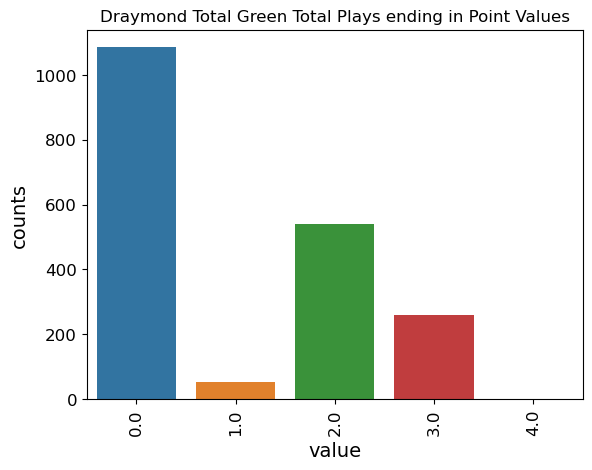

In [227]:
green_points_hist = sns.barplot(data = green_points_data, y = "counts", x = "value").set(title = "Draymond Total Green Total Plays ending in Point Values")
plt.xticks(rotation = 90);


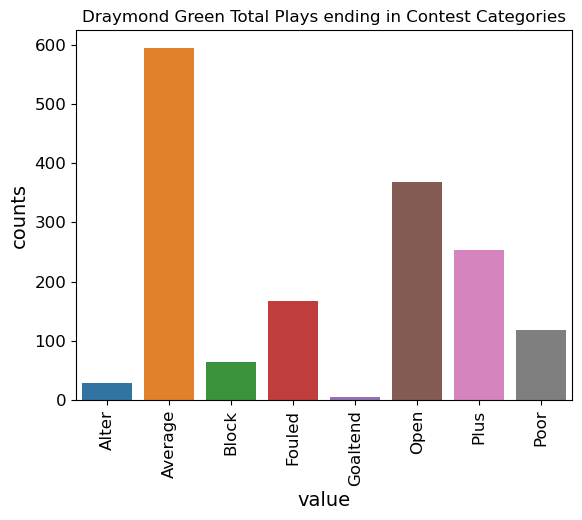

In [224]:
green_contest_hist = sns.barplot(data = green_contest_data, y = "counts", x = "value").set(title = "Draymond Green Total Plays ending in Contest Categories")
plt.xticks(rotation = 90);

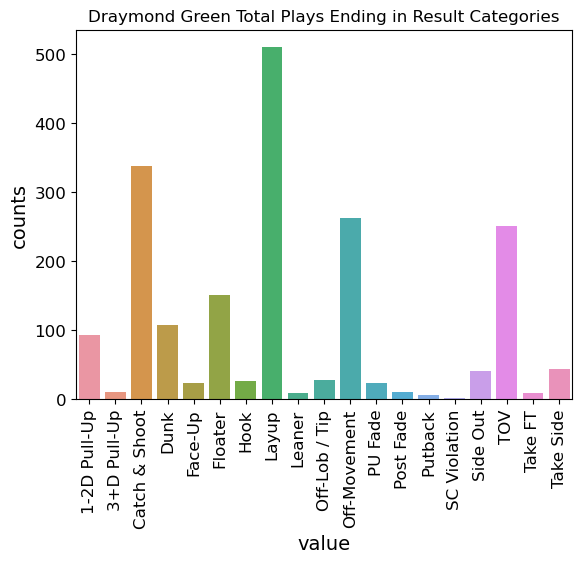

In [225]:
green_result_hist = sns.barplot(data = green_result_data, y = "counts", x = "value").set(title = "Draymond Green Total Plays Ending in Result Categories")
plt.xticks(rotation = 90);

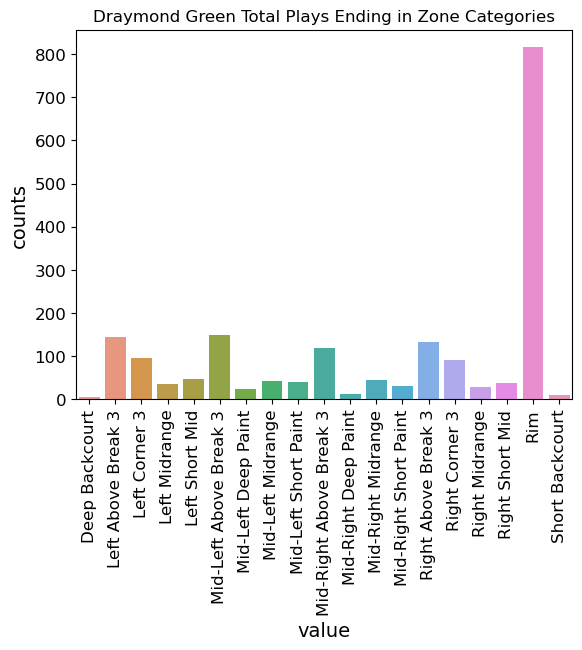

In [226]:
green_zone_hist = sns.barplot(data = green_zone_data, y = "counts", x = "value").set(title = "Draymond Green Total Plays Ending in Zone Categories")
plt.xticks(rotation = 90);

## Looney Histograms

In [228]:
looney_points_data.reset_index(inplace = True)
looney_contest_data.reset_index(inplace = True)
looney_result_data.reset_index(inplace = True)
looney_zone_data.reset_index(inplace = True)

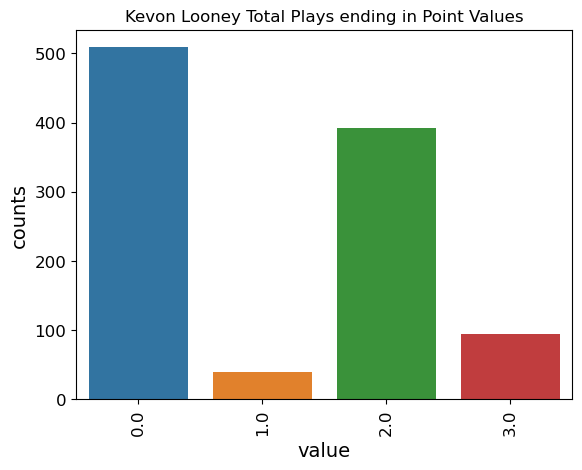

In [229]:
looney_points_hist = sns.barplot(data = looney_points_data, y = "counts", x = "value").set(title = "Kevon Looney Total Plays ending in Point Values")
plt.xticks(rotation = 90);


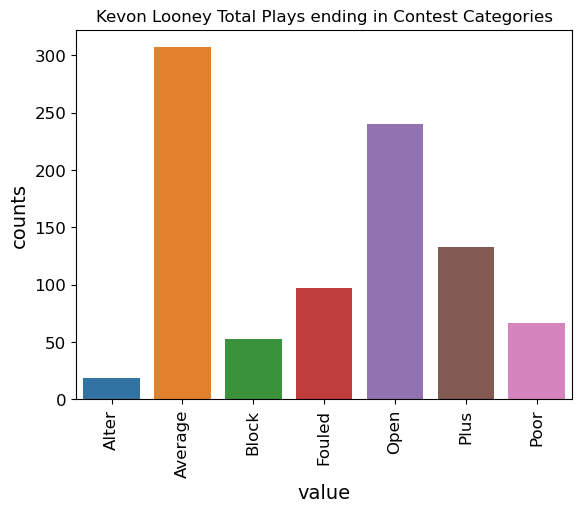

In [230]:
looney_contest_hist = sns.barplot(data = looney_contest_data, y = "counts", x = "value").set(title = "Kevon Looney Total Plays ending in Contest Categories")
plt.xticks(rotation = 90);

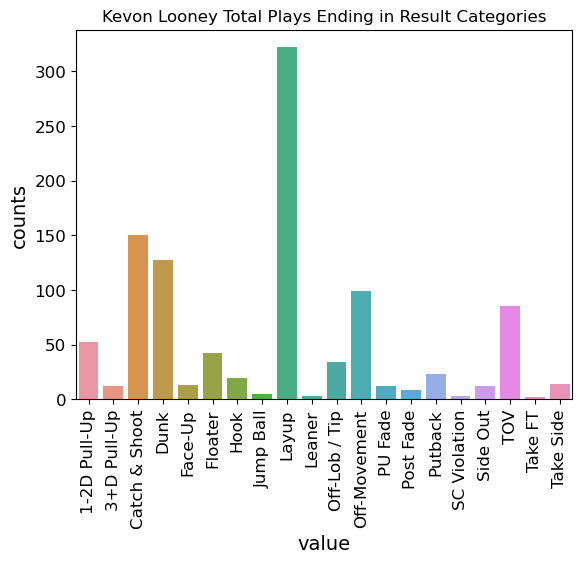

In [231]:
looney_result_hist = sns.barplot(data = looney_result_data, y = "counts", x = "value").set(title = "Kevon Looney Total Plays Ending in Result Categories")
plt.xticks(rotation = 90);

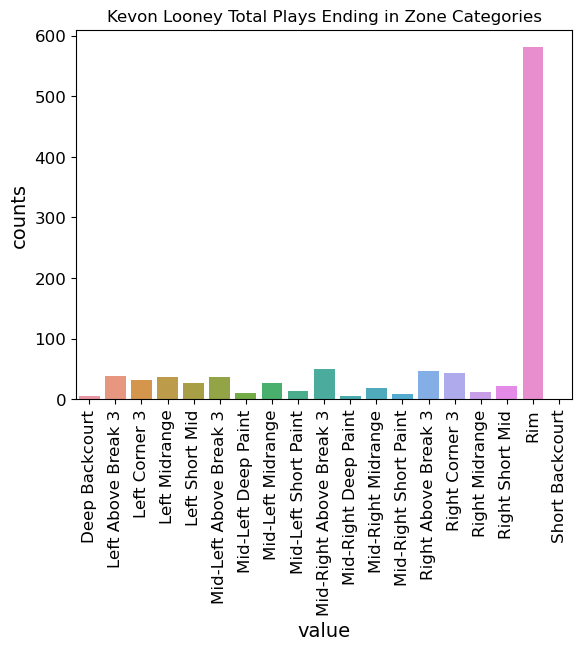

In [232]:
looney_zone_hist = sns.barplot(data = looney_zone_data, y = "counts", x = "value").set(title = "Kevon Looney Total Plays Ending in Zone Categories")
plt.xticks(rotation = 90);

## Curry Histograms

In [233]:
curry_points_data.reset_index(inplace = True)
curry_contest_data.reset_index(inplace = True)
curry_result_data.reset_index(inplace = True)
curry_zone_data.reset_index(inplace = True)

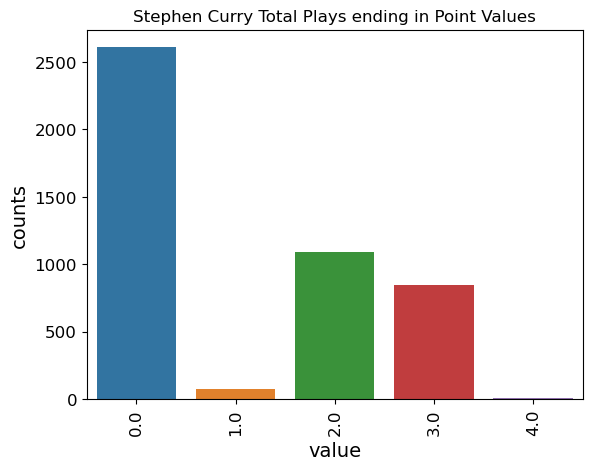

In [234]:
curry_points_hist = sns.barplot(data = curry_points_data, y = "counts", x = "value").set(title = "Stephen Curry Total Plays ending in Point Values")
plt.xticks(rotation = 90);


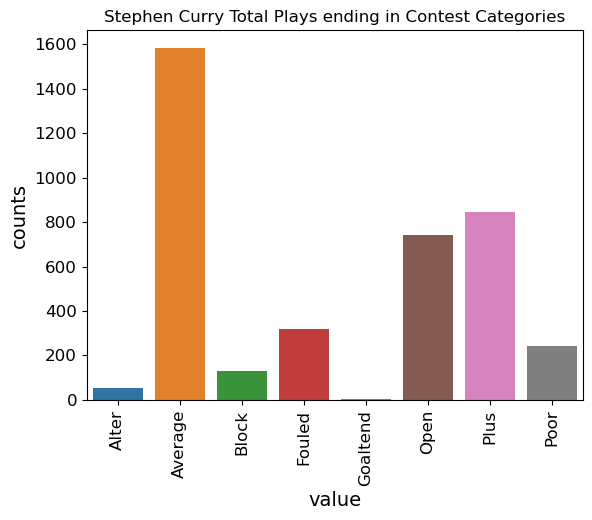

In [235]:
curry_contest_hist = sns.barplot(data = curry_contest_data, y = "counts", x = "value").set(title = "Stephen Curry Total Plays ending in Contest Categories")
plt.xticks(rotation = 90);

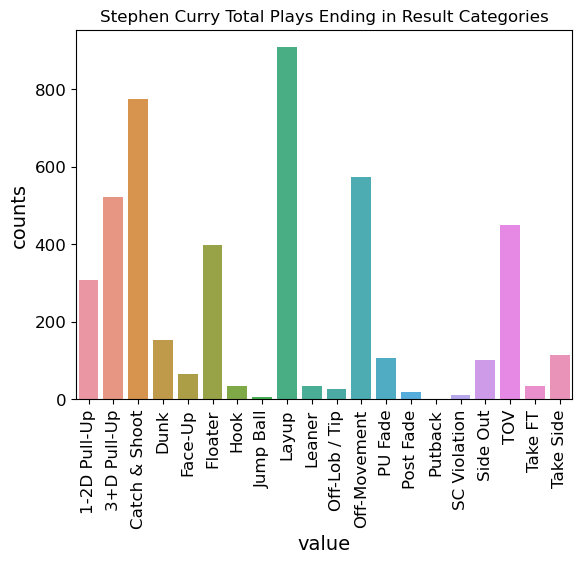

In [236]:
curry_result_hist = sns.barplot(data = curry_result_data, y = "counts", x = "value").set(title = "Stephen Curry Total Plays Ending in Result Categories")
plt.xticks(rotation = 90);

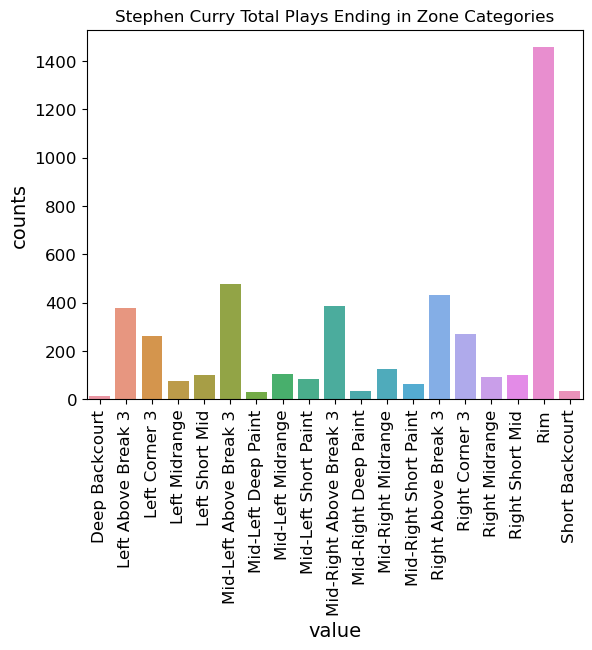

In [237]:
curry_zone_hist = sns.barplot(data = curry_zone_data, y = "counts", x = "value").set(title = "Stephen Curry Total Plays Ending in Zone Categories")
plt.xticks(rotation = 90);